# Predicting prices with a single-asset regression model

## Preparing the independent and target variables

In [1]:
from alpha_vantage.timeseries import TimeSeries

# Update your Alpha Vantage API key here...
ALPHA_VANTAGE_API_KEY = 'PZ2ISG9CYY379KLI'

ts = TimeSeries(key=ALPHA_VANTAGE_API_KEY, output_format='pandas')
df_jpm, meta_data = ts.get_daily_adjusted(
    symbol='JPM', outputsize='full')
df_gs, meta_data = ts.get_daily_adjusted(
    symbol='GS', outputsize='full')

In [2]:
import numpy as np
import pandas as pd

df_x = pd.DataFrame({'GS': df_gs['5. adjusted close']})[::-1]
df_x

,GS
date,
1999-11-01,54.352952
1999-11-02,54.642813
1999-11-03,53.859404
1999-11-04,54.940509
1999-11-05,57.729447
...,...
2020-11-25,235.272803
2020-11-27,234.138911
2020-11-30,229.344732


In [3]:
df_x.head()

,GS
date,
1999-11-01,54.352952
1999-11-02,54.642813
1999-11-03,53.859404
1999-11-04,54.940509
1999-11-05,57.729447


In [4]:
df_jpm

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
date,,,,,,,,
2020-12-02,119.70,122.3100,119.2700,122.04,122.040000,10811255.0,0.0,1.0
2020-12-01,120.34,121.5800,119.6276,119.74,119.740000,12287069.0,0.0,1.0
2020-11-30,120.00,120.7199,117.7700,117.88,117.880000,14411847.0,0.0,1.0
2020-11-27,122.00,122.3500,121.0800,121.22,121.220000,5983627.0,0.0,1.0
2020-11-25,121.37,122.3800,120.4650,122.03,122.030000,11715627.0,0.0,1.0
...,...,...,...,...,...,...,...,...
1999-11-05,86.13,87.3800,85.6200,86.25,30.004552,3433267.0,0.0,1.0
1999-11-04,83.88,85.9400,83.5000,84.12,29.263570,3869600.0,0.0,1.0
1999-11-03,83.62,84.0000,82.1900,82.44,28.679134,2648800.0,0.0,1.0


In [5]:
jpm_prices = df_jpm['5. adjusted close'][::-1]

In [6]:
jpm_prices.head()

date
1999-11-01    29.068758
1999-11-02    29.113982
1999-11-03    28.679134
1999-11-04    29.263570
1999-11-05    30.004552
Name: 5. adjusted close, dtype: float64

## Writing the linear regression model

In [7]:
from sklearn.linear_model import LinearRegression

class LinearRegressionModel(object):
    def __init__(self):
        self.df_result = pd.DataFrame(columns=['Actual', 'Predicted'])

    def get_model(self):
        return LinearRegression(fit_intercept=False)

    def learn(self, df, ys, start_date, end_date, lookback_period=20):
        model = self.get_model()

        for date in df[start_date:end_date].index:
            # Fit the model
            x = self.get_prices_since(df, date, lookback_period)
            y = self.get_prices_since(ys, date, lookback_period)
            model.fit(x, y.ravel())

            # Predict the current period
            x_current = df.loc[date].values
            [y_pred] = model.predict([x_current])

            # Store predictions
            new_index = pd.to_datetime(date, format='%Y-%m-%d')
            y_actual = ys.loc[date]
            self.df_result.loc[new_index] = [y_actual, y_pred]

    def get_prices_since(self, df, date_since, lookback):
        index = df.index.get_loc(date_since)
        return df.iloc[index-lookback:index]

In [8]:
# def get_prices_since(df, date_since, lookback):
#     index = df.index.get_loc(date_since)
#     return df.iloc[index-lookback:index]

# df = df_x
# ys = jpm_prices
# start_date, end_date = '2019-01-01', '2019-12-31'
# lookback_period=20

# df_result = pd.DataFrame(columns=['Actual', 'Predicted'])

# for date in df[start_date:end_date].index:
#     print(date)
#     # Fit the model
#     x = get_prices_since(df, date, lookback_period)
#     y = get_prices_since(ys, date, lookback_period)
#     model.fit(x, y.ravel())

#     # Predict the current period
#     x_current = df.loc[date].values
#     [y_pred] = model.predict([x_current])

#     # Store predictions
#     new_index = pd.to_datetime(date, format='%Y-%m-%d')
#     y_actual = ys.loc[date]
#     df_result.loc[new_index] = [y_actual, y_pred]

In [9]:
jpm_prices

date
1999-11-01     29.068758
1999-11-02     29.113982
1999-11-03     28.679134
1999-11-04     29.263570
1999-11-05     30.004552
                 ...    
2020-11-19    115.560000
2020-11-20    114.570000
2020-11-23    117.870000
2020-11-24    123.320000
2020-11-25    122.030000
Name: 5. adjusted close, Length: 5303, dtype: float64

In [10]:
linear_reg_model = LinearRegressionModel()
linear_reg_model.learn(df_x, jpm_prices, start_date='2018', 
                       end_date='2020', lookback_period=20)

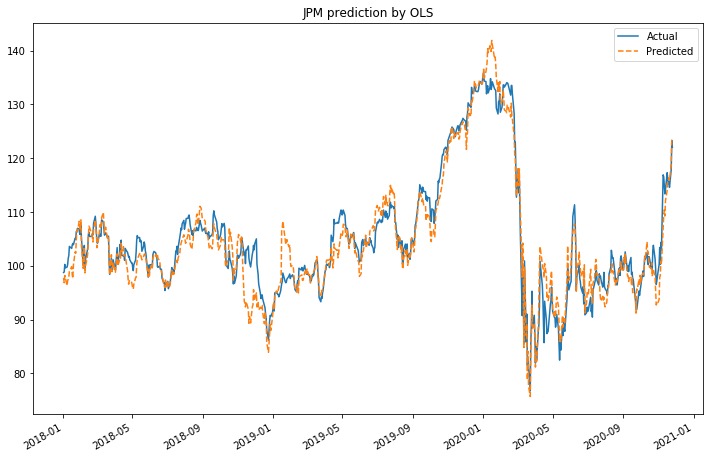

In [11]:
%matplotlib inline

linear_reg_model.df_result.plot(
    title='JPM prediction by OLS', 
    style=['-', '--'], figsize=(12,8));

In [12]:
res = linear_reg_model.df_result.copy()
res.head()

,Actual,Predicted
2018-01-02,98.750209,97.740575
2018-01-03,98.850834,96.847687
2018-01-04,100.259591,98.202580
2018-01-05,99.615958,97.719692
2018-01-08,99.763074,96.302862


In [13]:
# res['Actual'].diff()

In [14]:
# (np.sign(res['Predicted'].shift(-1) - res['Actual']).shift() * res['Actual'].diff()).cumsum().plot(figsize=(12,8));

## Risk metrics for measuring prediction performance

### Mean absolute error (MAE) as a risk metric

In [15]:
from sklearn.metrics import mean_absolute_error

actual = linear_reg_model.df_result['Actual']
predicted = linear_reg_model.df_result['Predicted']

mae = mean_absolute_error(actual, predicted)
print('mean absolute error:', mae)

mean absolute error: 2.285462328386474


#### Mean squared error (MSE) as a risk metric

In [16]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(actual, predicted)
print('mean squared error:', mse)

mean squared error: 9.776374596082105


### Explained variance score as a risk metric

In [17]:
from sklearn.metrics import explained_variance_score
eva = explained_variance_score(actual, predicted)
print('explained variance score:', eva)

explained variance score: 0.9226366766451356


### R<sup>2</sup> as a risk metric

In [18]:
from sklearn.metrics import r2_score
r2 = r2_score(actual, predicted) 
print('r2 score:', r2)

r2 score: 0.92117791710669


## Ridge regression

In [23]:
from sklearn.linear_model import Ridge

class RidgeRegressionModel(LinearRegressionModel):        
    def get_model(self):
        return Ridge(alpha=.5)

In [24]:
ridge_reg_model = RidgeRegressionModel()
ridge_reg_model.learn(df_x, jpm_prices, start_date='2018', 
                      end_date='2019', lookback_period=20)

In [25]:
from sklearn.metrics import (
    accuracy_score, mean_absolute_error, 
    explained_variance_score, r2_score
)
def print_regression_metrics(df_result):
    actual = list(df_result['Actual'])
    predicted = list(df_result['Predicted'])
    print('mean_absolute_error:', 
          mean_absolute_error(actual, predicted))
    print('mean_squared_error:', mean_squared_error(actual, predicted))
    print('explained_variance_score:', 
        explained_variance_score(actual, predicted))
    print('r2_score:', r2_score(actual, predicted))    

In [22]:
print_regression_metrics(ridge_reg_model.df_result)

mean_absolute_error: 1.3848472478426046
mean_squared_error: 3.5887619021876467
explained_variance_score: 0.9561803757959388
r2_score: 0.9527982083910924
